In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
from PIL import Image
import sklearn

# Pristup datasetu

In [3]:
print(os.listdir("/kaggle/input/papsmeardatasets/"))
Herlev = "/kaggle/input/papsmeardatasets/herlev_pap_smear/"
Sipak = "/kaggle/input/papsmeardatasets/sipakmed_fci_pap_smear/"

['herlev_pap_smear', 'sipakmed_wsi_pap_smear', 'sipakmed_fci_pap_smear']


In [4]:
Lista_H = os.listdir(Herlev)

Resizeanje slika na 64 x 64 za CNN.
Davanje labela ( abnormalna = 1, normalna = 0).
Vraća listu slika i labela.

In [6]:
def get_data(Dir):
    X = []
    y = []
    
    for dir_name in Dir:
        for nextDir in os.listdir(dir_name):
            if not nextDir.startswith('.'):
                if nextDir.startswith('normal'):
                    label = 0
                elif nextDir.startswith('abnormal') or nextDir.startswith('benign'):
                    label = 1
                


                temp = dir_name + nextDir

                for file in tqdm(os.listdir(temp)):
                    if not file.endswith('d.bmp') and not file.endswith('dat'):
                        img = cv2.imread(temp + '/' + file)
                        if img is not None:
                            img = skimage.transform.resize(img, (64,64,3))
                            #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                            img = np.asarray(img)
                            X.append(img)
                            y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [7]:
Lista = [Herlev, Sipak]

Postavljamo X_train na sve slike, y_train sve labele.

In [8]:
X_train, y_train = get_data(Lista)

100%|██████████| 2493/2493 [00:12<00:00, 195.71it/s]


Import-anje svega što će nam trebati za izradu modela, te matplot.pyplot za crtanje grafova.



In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


Dijelimo dataset na trening i test. 85% dataseta koristimo za model, 15% za testiranje.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15)

Ispod je CNN za binarnu klasifikaciju (napravljen originalno za klasifikaciju mačaka i pasa, malo prilagođen) 

Za metriku se koristi Accuracy (osnovna metrika)  i Recall jer nas zanima koliko imamo FN rezultata, koje želimo izbjeći. 

Na slici dolje se može vidjeti kako mreža izgleda po slojevima. 

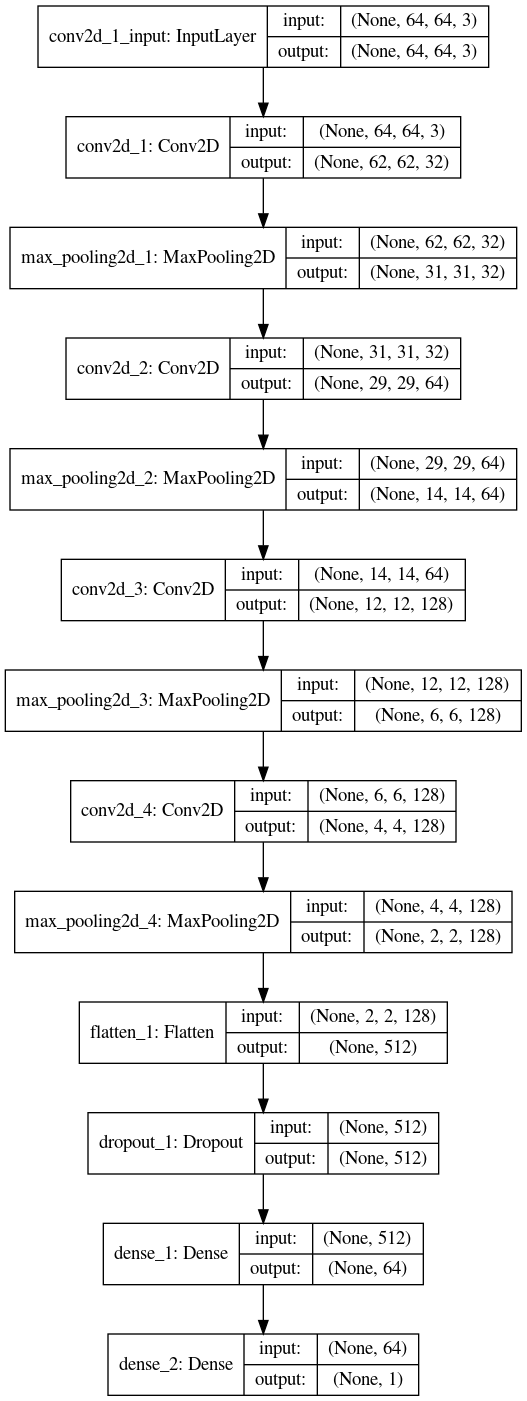

In [11]:
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dropout(0.4))
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =["accuracy",tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)])
#metrics =[ tf.keras.metrics.Recall()]
plot_model(classifier, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))


Treniranje mreže, 20 epoha, 10% se koristi za validaciju.

In [12]:


classifier.fit(X_train, y_train,validation_split = 0.1,  epochs=20)

Train on 3798 samples, validate on 423 samples
Epoch 1/20
3798/3798 [==============================] - 15s 4ms/step - loss: 0.5414 - accuracy: 0.7159 - recall: 0.8298 - val_loss: 0.4245 - val_accuracy: 0.8061 - val_recall: 0.8238
Epoch 2/20
3798/3798 [==============================] - 14s 4ms/step - loss: 0.3928 - accuracy: 0.8273 - recall: 0.8290 - val_loss: 0.4037 - val_accuracy: 0.8227 - val_recall: 0.8367
Epoch 3/20
3798/3798 [==============================] - 14s 4ms/step - loss: 0.3716 - accuracy: 0.8333 - recall: 0.8393 - val_loss: 0.3731 - val_accuracy: 0.8392 - val_recall: 0.8458
Epoch 4/20
3798/3798 [==============================] - 14s 4ms/step - loss: 0.3342 - accuracy: 0.8602 - recall: 0.8520 - val_loss: 0.3636 - val_accuracy: 0.8511 - val_recall: 0.8558
Epoch 5/20
3798/3798 [==============================] - 14s 4ms/step - loss: 0.3127 - accuracy: 0.8705 - recall: 0.8591 - val_loss: 0.3257 - val_accuracy: 0.8582 - val_recall: 0.8634
Epoch 6/20
3798/3798 [================

Na trening setu od 3798 slika i validacijskom setu od 423 uvježban je CNN. 

In [13]:

from matplotlib import pyplot
import matplotlib.pyplot as plt

In [14]:
print(classifier.history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'val_recall', 'loss', 'accuracy', 'recall'])


## Grafovi 

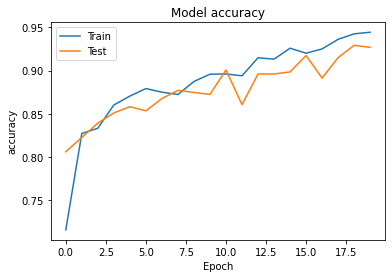

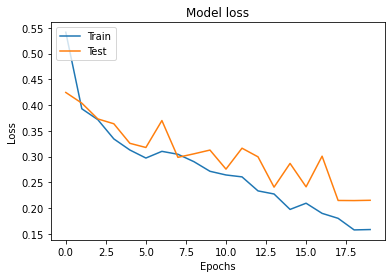

In [15]:
plt.plot(classifier.history.history['accuracy'])
plt.plot(classifier.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#history1.history['val_loss']
# Plot training & validation loss values
plt.plot(classifier.history.history['loss'])
plt.plot(classifier.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Na prvom grafu je prikazana usporedba accuracya na trening i validacijskom setu kroz epohe. 
Na drugom grafu je prikazana vrijednost loss funkcije kroz epohe na trening i validacijskom setu.

In [16]:
classifier.save('Cell_predict')

In [17]:
new_model = tf.keras.models.load_model('Cell_predict')

Predviđanje na testnom setu.

In [18]:
predictions = new_model.predict([X_test])

Pomoćni niz za precision i recall graf

In [19]:
niz = np.arange(0.0, 1.01, 0.01)

pomoćna funkcija za precision i recall graf

In [20]:
def zaok(a, x):
    if a >= x:
        return 1
    else:
        return 0

# Proučavanje predikcije za test set od 745 slika

In [21]:
y_test[0] == np.rint(predictions[0])

array([ True])

## Prebrojavanje TP, TN, FP, FN

In [22]:
TP = 0
FP = 0
TN = 0
FN = 0
for (i, j) in zip (y_test, predictions):
    if i == 0:
        if i == np.rint(j):
            TN += 1
        else:
            FP += 1
    elif i == 1:
        if i == np.rint(j):
            TP += 1
        else:
            FN += 1
     
            

In [23]:
print(TP, FP, TN, FN)

466 28 235 16


Funkcije za računanje precisiona i recalla.

In [24]:
def prec(TP,FP):
    return TP/(TP+FP)
def rec(TP, FN):
    return TP/(TP+FN)

## nizovi precision i recall za graf 

Mijenjamo "odlučujuću" vrijednost za određivanje klase stanice.

In [25]:
precision = []
recall = []
pom_pred = []

for k in niz:
    TP_1 = 0
    FP_1 = 0
    TN_1 = 0
    FN_1 = 0
    for (i, j) in zip (y_test, predictions):
        if i == 0:
            if i == zaok(j, k):
                TN_1 += 1
            else:
                FP_1 += 1
        elif i == 1:
            if i == zaok(j, k):
                TP_1 += 1
            else:
                FN_1 += 1
    precision.append(prec(TP_1,FP_1))
    recall.append(rec(TP_1,FN_1))
    
    
    

### Broj pogrešnih predikcija

In [26]:
brojac = 0

for (i, j) in zip (y_test, predictions):
    if i != np.rint(j):
        brojac += 1
    

### Accuracy


In [27]:
accu = 1 - brojac/len(y_test)

In [28]:
print('Accuracy je:', accu)

Accuracy je: 0.9409395973154362


Recall

In [29]:
Rec_ = TP/(FN+TP)

In [30]:
print(Rec_)

0.966804979253112


Precision

In [31]:
Pre_ = TP/(FP+TP)

In [32]:
print(Pre_)

0.9433198380566802


Graf: Precision i recall, u ovisnosti o "decision" funkciji.

Text(1, 1.1, 'Najbolji Recall i precision')

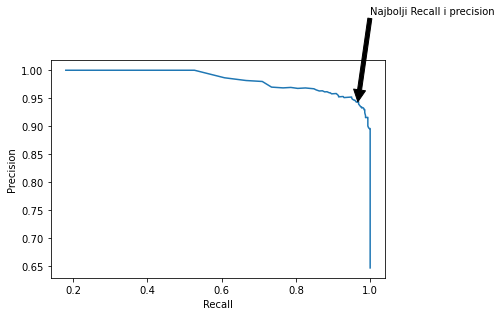

In [33]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.annotate('Najbolji Recall i precision', xy=(Rec_, Pre_), xytext=(1, 1.1),
            arrowprops=dict(facecolor='black', shrink=0.002),
            )

# Matrica konfuzije

arr je niz predviđanja za testni set (niz nula i jedinica) 

In [35]:
arr = np.rint(predictions)

In [37]:
cm = sklearn.metrics.confusion_matrix(y_test,arr)

In [38]:
from sklearn.metrics import plot_confusion_matrix

In [39]:
cm

array([[235,  28],
       [ 16, 466]])

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

cn = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(cm)
x=x.style.background_gradient(cmap=cn)
display(x)

,0,1
0,235,28
1,16,466


In [41]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools


## Matrica konfuzije veća


Text(0.5, -13.802484617611796, 'Predicted label')

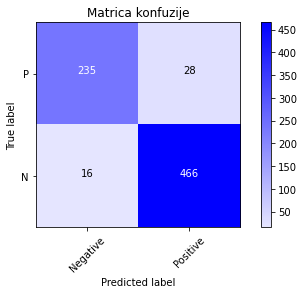

In [42]:
plt.imshow(cm, interpolation='nearest', cmap=cn)
plt.title("Matrica konfuzije")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
plt.yticks(tick_marks, ['P', 'N'])

#if normalize:
#    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#    print("Normalized confusion matrix")
#else:
#    print('Confusion matrix, without normalization')

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')